# Extra Material: Cutting Stock

The cutting stock problem is familiar to anyone who has cut parts out of stock materials. In the one-dimensional case, the stock materials are available in predetermined lengths and prices. The task is to cut a specific parts from the stocks materials. The question is then: how should one determine which parts to cut from each piece of stock material to minimize cost? This problem applies broadly to commercial applications, including the allocation of non-physical resources like capital budgeting or resource allocation.

This notebook presents several models and solution algorithms for the cutting stock problem.


In [1]:
# install Pyomo and solvers
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre >/dev/null 2>/dev/null
    !idaes get-extensions --to ./bin 
    os.environ['PATH'] += ':bin'
    
SOLVER_MILO = "cbc"
SOLVER_MINLO = "couenne"

## Problem formulation

Consider a set ${S}$ of available stock materials that can be cut to size to produce a set of finished parts. Each stock $s\in S$ is characterized by a length $l^S_s$, costs $c_s$ per piece, and is available in unlimited quantity. A customer order is received to product a set of finished products $F$. Each finished product $f\in F$ is specified by a required number $d_f$ and length $l^F_f$. The **cutting stock problem** find a minimum cost solution to fulfilling the customer order by cutting finished products from the available stocks.

This problem is illustrated is by the following tables of data for the example given by Gilmore and Gamory (1961).

**Stocks**

| stocks <br> $s$ | length <br> $l^S_s$ | cost <br> $c_s$ |
| :--: | :--: | :--: |
| A | 5 | 6 |
| B | 6 | 7 |
| C | 9 |10 |

**Finished Parts**

| finished parts <br> $f$ | length <br> $l^F_f$ | demand <br> $d_f$ |
| :--: | :--: | :--: |
| S | 2 | 20 |
| M | 3 | 10 |
| L | 4 | 20 |

This information is represented in Python as nested dictionaries using the stock and finished part labels as keys.

In [2]:
stocks = {
    'A': {'length': 5, 'cost': 6},
    'B': {'length': 6, 'cost': 7},
    'C': {'length': 9, 'cost': 10},
}

finish = {
    'S': {'length': 2, 'demand': 20},
    'M': {'length': 3, 'demand': 10},
    'L': {'length': 4, 'demand': 20},
}

## Patterns

One approach to solving this problem would be creating a list of each finished parts, a list of stocks of each length, then a set of binary decision variables assigning each finished product to a particular piece of stock. The objective would be to minimize the cost of stock required to produced the finished parts. This approach might work well for a  small problem, but the computational complexity would scale too rapidly with the size of the problem to be practical for business applications.

To address computational complexity, Gilmore and Gamory introduced an additional data structure that they called "activities" and that are now referred to as "patterns" in the current literature. A pattern is recipe for cutting a single stock item into one or more finished parts. Each pattern $p$ is specified by the stock $s_p$ used for the pattern, and by a set of integers $a_{pf}$ for $f\in F$ that specify the number of finished parts of type $f$ cut from stock $s_p$. 

A pattern $p\in P$ is feasible for stock $s_p\in S$ if 

$$
\begin{align}
\sum_{f\in F}a_{pf}l^F_f  & \leq   l^S_{s_p}
\end{align}
$$

The following cell presents a simple Pyomo model to produce a list of feasible patterns for given sets of stocks and finished products. Each pattern is a dictionary that specifies an associated stock item, and a dictionary of cuts that give the number of finished parts of each type that are cut from the stock.

In [3]:
# create a list of feasible patterns

def make_patterns(stocks, finish):
    patterns = []
    for s in stocks:
        for f in finish:
            a = {f: 0 for f in finish}
            a[f] = int(stocks[s]['length']/finish[f]['length'])
            patterns.append({'stock': s, 'cuts': a})    
    return patterns

patterns = make_patterns(stocks, finish)
patterns

[{'stock': 'A', 'cuts': {'S': 2, 'M': 0, 'L': 0}},
 {'stock': 'A', 'cuts': {'S': 0, 'M': 1, 'L': 0}},
 {'stock': 'A', 'cuts': {'S': 0, 'M': 0, 'L': 1}},
 {'stock': 'B', 'cuts': {'S': 3, 'M': 0, 'L': 0}},
 {'stock': 'B', 'cuts': {'S': 0, 'M': 2, 'L': 0}},
 {'stock': 'B', 'cuts': {'S': 0, 'M': 0, 'L': 1}},
 {'stock': 'C', 'cuts': {'S': 4, 'M': 0, 'L': 0}},
 {'stock': 'C', 'cuts': {'S': 0, 'M': 3, 'L': 0}},
 {'stock': 'C', 'cuts': {'S': 0, 'M': 0, 'L': 2}}]

Text(0.5, 1.0, 'Patterns')

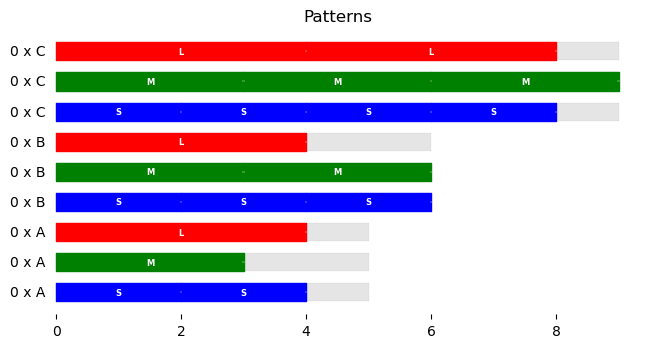

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_patterns(stocks, finish, patterns, x=[0]*len(patterns)):
    lw = 0.3
    fig, ax = plt.subplots(1, 1, figsize=(8, 0.1 + 0.4*len(patterns)))
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    colors = {f: colors[k % len(colors)] for k, f in enumerate(finish.keys())}
    for k, pattern in enumerate(patterns):
        s = pattern['stock']      
        ax.text(-0.1, k, f"{int(x[k])} x {s} " if x[k] > 0 else f"0 x {s} ", ha="right", va="center")
        ax.fill_between((0, stocks[s]['length']), (k - lw, k - lw), (k + lw, k + lw), color="k", lw=lw, alpha=0.1)
        xa = 0
        for f, n  in pattern['cuts'].items():
            length = finish[f]['length']
            for q in range(n):
                xb = xa + length
                ax.fill_between((xa, xb), (k - lw, k - lw), (k + lw, k + lw), alpha=1.0, color=colors[f])
                ax.text((xa + xb)/2, k, f, fontsize=6, color="w", weight="bold", ha="center", va="center")
                ax.plot((xb-0.02, xb+0.02), (k, k), solid_capstyle="butt", lw=lw, color="w")
                xa = xb 
    ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
    ax.set_yticks(())
    return ax

ax = plot_patterns(stocks, finish, patterns)
ax.set_title("Patterns")

## Optimal cutting using known patterns

Given a list of patterns, the optimization problem is to compute how many copies of each pattern to cut to meet the demand for finished parts at minimum cost. Let the index $s_p$ denote the stock specified by pattern $p$, and let $x_{s_p}$ denote the number pieces of stock $s_p$ is used.

For a given list of patterns, the minimum cost optimization problem is then a mixed integer linear optimization problem subject to meeting demand constraints for each finished item.

$$
\begin{align}
\min & \sum_{p\in P} c_{s_p} x_{s_p} \\
\text{s.t.}\qquad
& \sum_{p\in P}a_{pf} x_{s_p} \geq d_f && \forall f\in F\\
& x_{s_p}  \in \mathbb{Z}_+ && \forall p\in P\\
\end{align}
$$

The next cell is a Pyomo implementation of this optimization model.

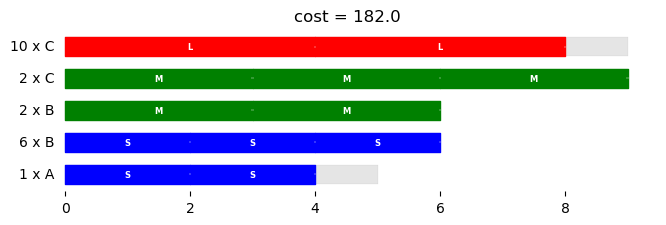

In [5]:
import pyomo.environ as pyo

# Given dictionaries of stocks and finished parts, and a list of patterns, 
# find minimum choice of patterns to cut

def cut_patterns(stocks, finish, patterns):
    m = pyo.ConcreteModel()

    m.S = pyo.Set(initialize=list(stocks.keys()))
    m.F = pyo.Set(initialize=list(finish.keys()))
    m.P = pyo.RangeSet(0, len(patterns)-1)
    
    m.x = pyo.Var(m.P, domain=pyo.NonNegativeIntegers)

    @m.Objective(sense=pyo.minimize)
    def cost(m):
        s = {p: patterns[p]['stock'] for p in m.P}
        c = {p:  stocks[s[p]]['cost'] for p in m.P}
        return sum(c[p] * m.x[p] for p in m.P)

    @m.Constraint(m.F)
    def demand(m, f):
        a = {p: patterns[p]['cuts'][f] for p in m.P}
        return sum(a[p] * m.x[p] for p in m.P) >= finish[f]['demand']
    
    solver = pyo.SolverFactory('cbc')
    solver.solve(m)

    return m

m = cut_patterns(stocks, finish, patterns)
x = [m.x[p]() for p in m.P]
k = [k for k, p in enumerate(m.P) if m.x[p]() > 0]

ax = plot_patterns(stocks, finish, [patterns[k] for k in k], [x[k] for k in k])
ax.set_title(f"cost = {m.cost()}");

## Cutting Stock Problem: Bilinear reformulation

The `cut_patterns` model requires a list cutting patterns, which may or may not include the patterns corresponding to an optimal solution cutting stock problem. To address this issue, we next create a model that simultaneously solves for an optimal patterns and cutting list.

Let binary variable $b_{sp}\in\mathbb{Z}_2$ denote the assignment of stock $s$ to pattern $p$, and let $P = 0, 1, \ldots, N_p-1$ index a list of patterns. For sufficiently large $N_p$, an optimal solution to the stock cutting problem is given by the model

$$
\begin{align}
\min & \sum_{s\in S} \sum_{p\in P} c_{s} b_{sp} x_{p} \\
\text{s.t.}\qquad
& \sum_{s\in S}b_{sp} =  1 && \forall p\in P \\
& \sum_{f\in F}a_{fp}l^F_f  \leq \sum_{s\in S} b_{sp} l^S_s && \forall p\in P \\
& \sum_{p\in P}a_{fp} x_{p} \geq d_f && \forall f\in F\\
& a_{fp}, x_p  \in \mathbb{Z}_+ && \forall f\in F,  \forall p\in P \\
& b_{sp} \in \mathbb{Z}_2 && \forall s\in S,  \forall p\in P \\
\end{align}
$$

This is a challenging optimization problem with a cost objective that is bilinear with respect to the the decision variables $b_{sp}$ and $x_p$, and a set of constraints for the demand of finished parts that are bilinear in the decision variables $a_{fp}$ and $x_p$.s Because the constraints are a lower bound on a positive sum of bilinear terms, a simple substitution to create rotated quadratic cones fails to produce a convex conic program.

The following model is a direct translation of the bilinear optimization model into Pyomo.

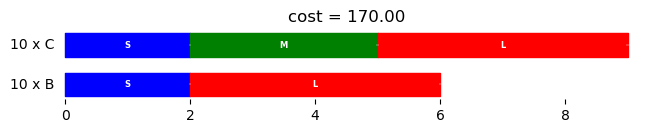

In [6]:
import pyomo.environ as pyo

def bilinear_cut_stock(stocks, finish, Np):
    m = pyo.ConcreteModel()

    m.S = pyo.Set(initialize=list(stocks.keys()))
    m.F = pyo.Set(initialize=list(finish.keys()))
    m.P = pyo.RangeSet(0, Np-1)

    m.a = pyo.Var(m.F, m.P, domain=pyo.NonNegativeIntegers)
    m.b = pyo.Var(m.S, m.P, domain=pyo.Binary)
    m.x = pyo.Var(m.P, domain=pyo.NonNegativeIntegers)

    # minimize cost
    @m.Objective(sense=pyo.minimize)
    def cost(m):
        c = {s:  stocks[s]['cost'] for s in m.S}
        return sum(c[s]* m.b[s, p] * m.x[p] for s in m.S for p in m.P)

    # assign one stock to each pattern
    @m.Constraint(m.P)
    def assign_each_stock_to_pattern(m, p):
        return sum(m.b[s, p] for s in m.S) == 1

    # pattern feasibility
    @m.Constraint(m.P)
    def feasible_pattern(m, p):
        return sum(m.a[f, p] * finish[f]['length'] for f in m.F) <= sum(m.b[s, p] * stocks[s]['length'] for s in m.S)

    # demand constraints
    @m.Constraint(m.F)
    def demand(m, f):
        return sum(m.a[f, p] * m.x[p] for p in m.P) >= finish[f]['demand']

    pyo.SolverFactory('couenne').solve(m)
    
    return m


m = bilinear_cut_stock(stocks, finish, 2)

soln_patterns = []
for p in m.P:
    a = {f: round(m.a[f, p]()) for f in m.F}
    soln_patterns.append({'stock': [s for s in m.S if m.b[s, p]() > 0][0], 'cuts': a})
    
x = [round(m.x[p]()) for p in m.P]
ax = plot_patterns(stocks, finish, soln_patterns, x)
ax.set_title(f"cost = {m.cost():0.2f}");

## Pattern generation

From limited testing, the bilinear model for the cutting stock problem appears to work well for small data sets, but does not scale well for larger problem instances, at least with the solvers included in the testing. This shouldn't be surprising given the non-convex nature of the problem, the exclusive use of integer and binary decision variables, and a high degree of symmetry in the model equations.

$$
\begin{align}
\min & \sum_{p\in P} c_{s_p} x_{s_p} + x' \sum_{s\in S} b_s c_s\\
\text{s.t.}\qquad
& \sum_{s\in S}b'_{s} =  1  \\
& \sum_{f\in F}a'_{f}l^F_f  \leq \sum_{s\in S} b'_{s} l^S_s  \\
& \sum_{p\in P}a_{fp} x_{s_p}  + a'_f x'\geq d_f && \forall f\in F\\
& a'_{f}, x_p  \in \mathbb{Z}_+ && \forall f\in F,  \forall p\in P \\
& b'_{s} \in \mathbb{Z}_2 && \forall s\in S \\
\end{align}
$$


In [7]:
def pattern_generation(stocks, finish, patterns):
    m = pyo.ConcreteModel()

    m.S = pyo.Set(initialize=list(stocks.keys()))
    m.F = pyo.Set(initialize=list(finish.keys()))
    m.P = pyo.RangeSet(0, len(patterns)-1)
    
    m.x = pyo.Var(m.P, domain=pyo.NonNegativeReals)
    m.xp = pyo.Var(domain=pyo.NonNegativeReals)
    
    m.ap = pyo.Var(m.F, domain=pyo.NonNegativeIntegers)
    m.bp = pyo.Var(m.S, domain=pyo.Binary)

    @m.Objective(sense=pyo.minimize)
    def cost(m):
        s = {p: patterns[p]['stock'] for p in m.P}
        c = {p:  stocks[s[p]]['cost'] for p in m.P}
        return sum(c[p] * m.x[p] for p in m.P) + m.xp * sum(m.bp[s] * stocks[s]['cost'] for s in m.S)
    
    @m.Constraint()
    def sum_to_one(m):
        return sum(m.bp[s] for s in m.S) == 1
    
    @m.Constraint()
    def add_pattern(m):
        return sum(m.ap[f] * finish[f]['length'] for f in m.F) <= sum(m.bp[s] * stocks[s]['length'] for s in m.S)

    @m.Constraint(m.F)
    def demand(m, f):
        return sum(patterns[p]['cuts'][f] * m.x[p] for p in m.P) + m.ap[f] * m.xp >= finish[f]['demand']
    
    solver = pyo.SolverFactory('couenne')
    solver.solve(m)
    
    return m

In [8]:
stocks = {
    'A': {'length': 5, 'cost': 6},
    'B': {'length': 6, 'cost': 7},
    'C': {'length': 9, 'cost': 10},
}

finish = {
    'S': {'length': 2, 'demand': 20},
    'M': {'length': 3, 'demand': 10},
    'L': {'length': 4, 'demand': 20},
}

patterns = make_patterns(stocks, finish)
m = pattern_generation(stocks, finish, patterns)

new_pattern = {'stock': [s for s in m.S if m.bp[s]() > 0.5][0], 'cuts': {f: round(m.ap[f]()) for f in m.F}}

print(m.cost())
print(new_pattern)

173.3333319727273
{'stock': 'C', 'cuts': {'S': 1, 'M': 1, 'L': 1}}


## A Solution Algorithm

Iteration  0
Iteration  1
Iteration  2
Iteration  3

Finished


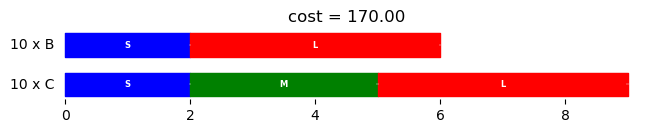

In [9]:
# an (inefficient) algorithm

def cutting_stock(stocks, finish):
    
    # create an initial list of patterns
    patterns = make_patterns(stocks, finish)
    
    done = False
    for k in range(20):
        print(f"Iteration {k:2}")
        m = pattern_generation(stocks, finish, patterns)
        new_pattern = {'stock': [s for s in m.S if m.bp[s]() > 0.5][0], 'cuts': {f: round(m.ap[f]()) for f in m.F}}
        
        # terminate if pattern no new patterns are being generated
        if new_pattern in patterns:
            done = True
            break
        else:
            patterns.append(new_pattern)
            
    if done:
        print("\nFinished")
        
        m = cut_patterns(stocks, finish, patterns)
        x = [round(m.x[p]()) for p in m.P]      
        idx = [p for p in m.P if m.x[p]() > 0.1]
        x = [round(m.x[p]()) for p in idx]
        patterns = [patterns[p] for p in idx]
        ax = plot_patterns(stocks, finish, patterns, x)
        ax.set_title(f"cost = {m.cost():0.2f}");
    else:
        print("\nDidn't Converge")
        
cutting_stock(stocks, finish)

Iteration  0
Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration 10

Finished


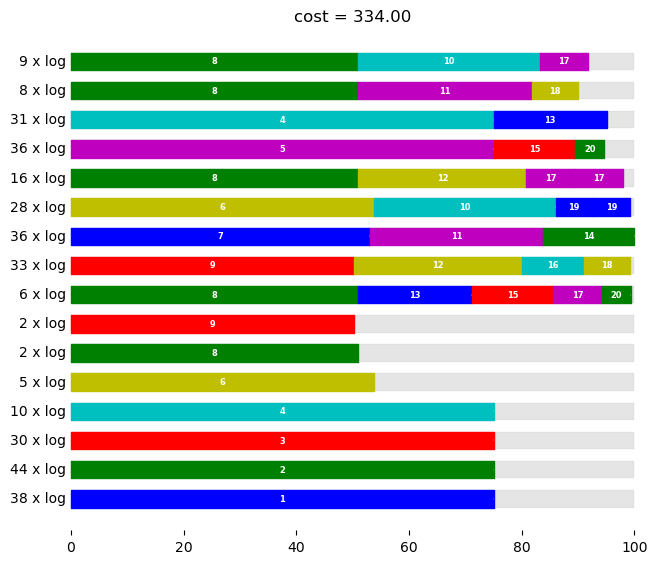

In [10]:
# https://jump.dev/JuMP.jl/stable/tutorials/algorithms/cutting_stock_column_generation/#:~:text=The%20cutting%20stock%20problem%20is,while%20maximizing%20the%20total%20profit.

stocks = {
    'log': {'length': 100, 'cost': 1},
}

finish = {
    1:  {'length': 75.0, 'demand': 38},
    2:  {'length': 75.0, 'demand': 44},
    3:  {'length': 75.0, 'demand': 30},
    4:  {'length': 75.0, 'demand': 41},
    5:  {'length': 75.0, 'demand': 36},
    6:  {'length': 53.8, 'demand': 33},
    7:  {'length': 53.0, 'demand': 36},
    8:  {'length': 51.0, 'demand': 41},
    9:  {'length': 50.2, 'demand': 35},
    10: {'length': 32.2, 'demand': 37},
    11: {'length': 30.8, 'demand': 44},
    12: {'length': 29.8, 'demand': 49},
    13: {'length': 20.1, 'demand': 37},
    14: {'length': 16.2, 'demand': 36},
    15: {'length': 14.5, 'demand': 42},
    16: {'length': 11.0, 'demand': 33},
    17: {'length':  8.6, 'demand': 47},
    18: {'length':  8.2, 'demand': 35},
    19: {'length':  6.6, 'demand': 49},
    20: {'length':  5.1, 'demand': 42},
}

cutting_stock(stocks, finish)

## Read problem data from Google sheets

https://docs.google.com/spreadsheets/d/1ZX7KJ2kwTGgyqEv_a3LOG0nQSxsc38Ykk53A7vGWAFU/edit#gid=1104632299

In [11]:
import pandas as pd

def read_google_sheet(sheet_id, sheet_name):
    """
    Reads a Google Sheet and returns a pandas DataFrame.

    This function reads a Google Sheet with the specified sheet ID and sheet name,
    and returns a pandas DataFrame with the data. The column names are converted to
    lowercase.

    Args:
        sheet_id (str): The Google Sheet ID.
        sheet_name (str): The name of the sheet to read.

    Returns:
        df (pd.DataFrame): A pandas DataFrame containing the data from the Google Sheet.
    """
    url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
    df = pd.read_csv(url)
    df.columns = map(str.lower, df.columns)
    return df

In [12]:
# Google Sheet ID
sheet_id = "1ZX7KJ2kwTGgyqEv_a3LOG0nQSxsc38Ykk53A7vGWAFU"

# read settings
settings_df = read_google_sheet(sheet_id, "settings")
print("\nSettings")
display(settings_df)

# read parts
finish_df = read_google_sheet(sheet_id, "finish")
print("\nFinish")
display(finish_df)

# read and display stocks
stocks_df = read_google_sheet(sheet_id, "stocks")
#stocks = stocks.drop(["price"], axis=1)
if not "price" in stocks_df.columns:
    stocks["price"] = stocks_df["length"]
print("\nStocks")
display(stocks_df)


Settings


,setting,value
0,kerf,0.125



Finish


,kind,length,quantity,label
0,2x4,29,8,legs
1,2x4,48,4,long aprons
2,2x4,18,4,short aprons
3,2x6,54,8,table top



Stocks


,kind,length,price
0,2x4,36,1.68
1,2x4,48,1.86
2,2x4,72,2.57
3,2x4,84,2.65
4,2x4,96,2.92
5,2x4,120,3.67
6,2x4,144,4.40
7,2x4,168,5.14
8,2x4,192,6.92
9,2x4,216,8.62


Kind = 2x6
Iteration  0

Finished
Kind = 2x4
Iteration  0
Iteration  1

Finished


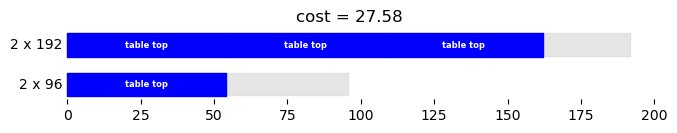

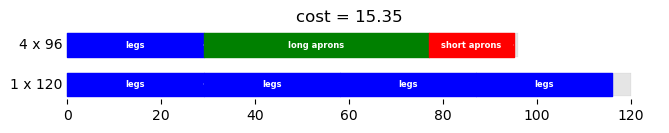

In [13]:
kinds = tuple(set(finish_df['kind']))

for kind in kinds:
    print(f"Kind = {kind}")
    
    finish = dict()
    for i in finish_df.loc[finish_df['kind'] == kind].index:
        finish[finish_df.loc[i, 'label']] = {'length': finish_df.loc[i, 'length'],
                                             'demand': finish_df.loc[i, 'quantity']}
        
    stocks = dict()
    for i in stocks_df.loc[stocks_df['kind'] == kind].index:
        stocks[stocks_df.loc[i, 'length']] = {'length': stocks_df.loc[i, 'length'],
                                             'cost': stocks_df.loc[i, 'price']}
    
    cutting_stock(stocks, finish)


## References

The one dimensional cutting stock problem addressed in this notebook is generally attributed to two classic papers by Gilmore and Gomory. This first paper considers the more general case of stocks available in multiple lengths, while the second paper specializes to the needs of a paper trimming operation.

> Gilmore, P. C., & Gomory, R. E. (1961). A linear programming approach to the cutting-stock problem. Operations research, 9(6), 849-859. [[jstor](https://www.jstor.org/stable/pdf/167051.pdf)]

> Gilmore, P. C., & Gomory, R. E. (1963). A linear programming approach to the cutting stock problem—Part II. Operations research, 11(6), 863-888. [[jstor](https://www.jstor.org/stable/pdf/167827.pdf)]

The solution proposed by Gilmore and Gamory has been refined over time and now generally referred to as "column generation". A number of tutorial implemenations are available, these are representative:

> * [Mathworks/Matlab: Cutting Stock Problem](https://www.mathworks.com/help/optim/ug/cutting-stock-problem-based.html)
* [AIMMS: Cutting Stock Problem](https://download.aimms.com/aimms/download/manuals/AIMMS3OM_CuttingStock.pdf)
* [SCIP:Bin packing and cutting stock problems](https://scipbook.readthedocs.io/en/latest/bpp.html)
* [PuLP: Implementation](https://github.com/coin-or/pulp/blob/master/examples/CGcolumnwise.py)

More recently, the essential bilinear structure of the problem has been noted, and various convex transformations of the problem have been studied:

> Harjunkoski, I., Westerlund, T., Pörn, R., & Skrifvars, H. (1998). Different transformations for solving non-convex trim-loss problems by MINLP. European Journal of Operational Research, 105(3), 594-603. [[abo.fi](http://users.abo.fi/twesterl/some-selected-papers/49.%20EJOR-IH-TW-RP-HS-1998.pdf)][[sciencedirect](https://www.sciencedirect.com/science/article/pii/S0377221797000660)]

> Harjunkoski, I., Pörn, R., & Westerlund, T. (1999). Exploring the convex transformations for solving non-convex bilinear integer problems. Computers & Chemical Engineering, 23, S471-S474. [[sciencedirect](https://www.sciencedirect.com/science/article/pii/S0098135499801161)